# Network creation

## Import libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import csv
import time
import sklearn
import random
import pathlib
import re
import shutil
import string
import logging
import os
from sklearn.utils import shuffle
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from tensorflow.keras import losses

seed = 50
tf.random.set_seed(seed)
np.random.seed(seed)

## Define functions

- ### Load and process dataset

In [ ]:
# load train and test dataset
def load_dataset(nodes_number, model_n,data):
    
    (x_train, y_train), (x_test, y_test) = data[0], data[1]
    (l1, l2) = (len(x_train),len(x_test))
    # reshape dataset to have a single channel
    x_Train = x_train.reshape((x_train.shape[0], 28, 28, 1))[int((model_n-1) * l1/nodes_number):int((model_n) * l1/nodes_number)]
    x_test = x_test.reshape((x_test.shape[0], 28, 28, 1))[int((model_n-1) * l2/nodes_number):int((model_n) * l2/nodes_number)]
    
    # one hot encode target values
    y_Train = keras.utils.to_categorical(y_train)[int((model_n-1) * l1/nodes_number):int((model_n) * l1/nodes_number)]
    y_test = keras.utils.to_categorical(y_test)[int((model_n-1) * l2/nodes_number):int((model_n) * l2/nodes_number)]
    
    return x_Train, y_Train, x_test, y_test
def prep_pixels(train,test):
    # convert from integers to floats and normalize
    train_norm = train.astype('float32') / 255.0
    test_norm = test.astype('float32') / 255.0
    return train_norm, test_norm
def add_noise(l1,l2,percent,x_train,y_train,x_test,y_test):
    # add bad data: random images
    n1 = int((1.0 - percent) * l1)
    n2 = int((1.0 - percent) * l2)
    if n1 > 0 and n2 > 0:
        x_noise1 = np.random.randint(low=0, high=255, size=(n1,28,28,1))
        y_noise1 = keras.utils.to_categorical(np.random.randint(low=0, high=10, size=n1),num_classes=10)
        x_noise2 = np.random.randint(low=0, high=255, size=(n2,28,28,1))
        y_noise2 = keras.utils.to_categorical(np.random.randint(low=0, high=10, size=n2),num_classes=10)
        
        x_train = np.append(x_train[0:(l1-n1)], x_noise1, axis=0)
        y_train = np.append(y_train[0:(l1-n1)], y_noise1, axis=0)
        x_test = np.append(x_test[0:(l2-n2)], x_noise2, axis=0)
        y_test = np.append(y_test[0:(l2-n2)], y_noise2, axis=0)
        
        x_train, y_train = shuffle(x_train, y_train, random_state=0)
        x_test, y_test = shuffle(x_test, y_test, random_state=0)

    return x_train, y_train, x_test, y_test

AUTOTUNE = tf.data.AUTOTUNE
def decode_audio(audio_binary):
    audio, _ = tf.audio.decode_wav(contents=audio_binary)
    return tf.squeeze(audio, axis=-1)
def get_label(file_path):
    parts = tf.strings.split(
      input=file_path,
      sep=os.path.sep)
    return parts[-2]
def get_waveform_and_label(file_path):
    if np.random.uniform(()) > good_data[pivot]:#generate wrong labels according to good_data percentage
        label = commands[random.randint(0,len(commands)-1)]
    else:
        label = get_label(file_path)
    audio_binary = tf.io.read_file(file_path)
    waveform = decode_audio(audio_binary)
    return waveform, label
def get_spectrogram(waveform):
    input_len = 16000
    waveform = waveform[:input_len]
    zero_padding = tf.zeros(
      [16000] - tf.shape(waveform),
      dtype=tf.float32)
    waveform = tf.cast(waveform, dtype=tf.float32)
    equal_length = tf.concat([waveform, zero_padding], 0)
    spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram)
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram
def get_spectrogram_and_label_id(audio, label):
    spectrogram = get_spectrogram(audio)
    label_id = tf.argmax(label == commands)
    return spectrogram, label_id
def preprocess_dataset(files):
    files_ds = tf.data.Dataset.from_tensor_slices(files)
    output_ds = files_ds.map(
        map_func=get_waveform_and_label,
        num_parallel_calls=AUTOTUNE)
    output_ds = output_ds.map(
        map_func=get_spectrogram_and_label_id,
        num_parallel_calls=AUTOTUNE)
    return output_ds
def load_dataset_speech(nodes_number, model_n,train,test,val):
    
    (l1, l2, l3) = (len(train),len(test),len(val))
    # reshape dataset to have a single channel
    train = train[int((model_n-1) * l1/nodes_number):int((model_n) * l1/nodes_number)]
    test = test[int((model_n-1) * l2/nodes_number):int((model_n) * l2/nodes_number)]
    val = val[int((model_n-1) * l3/nodes_number):int((model_n) * l3/nodes_number)]
    
    files_ds = tf.data.Dataset.from_tensor_slices(train)

    waveform_ds = files_ds.map(
        map_func=get_waveform_and_label,
        num_parallel_calls=AUTOTUNE)
    spectrogram_ds = waveform_ds.map(
        map_func=get_spectrogram_and_label_id,
        num_parallel_calls=AUTOTUNE)
    
    train_ds = spectrogram_ds
    val_ds = preprocess_dataset(val_files)
    test_ds = preprocess_dataset(test_files)
    batch_size = 64
    train_ds = train_ds.batch(batch_size)
    val_ds = val_ds.batch(batch_size)
    
    train_ds = train_ds.cache().prefetch(AUTOTUNE)
    val_ds = val_ds.cache().prefetch(AUTOTUNE)
    
    for spectrogram, _ in spectrogram_ds.take(1):
        input_shape = spectrogram.shape
        
    return train_ds, test_ds, val_ds, input_shape,spectrogram_ds

- ### Model definition

In [ ]:
def define_model(name,input_shape=0,spectrogram_ds=0,logs=1):
    if name == 'SPEECH':
        norm_layer = layers.Normalization()
        norm_layer.adapt(data=spectrogram_ds.map(map_func=lambda spec, label: spec))
        num_labels = len(commands)
        model = Sequential([
            layers.Input(shape=input_shape),
            layers.Resizing(32, 32),
            norm_layer,
            Conv2D(32, 3, activation='relu'),
            Conv2D(64, 3, activation='relu'),
            MaxPooling2D(),
            Dropout(0.25),
            Flatten(),
            Dense(128, activation='relu'),
            Dropout(0.5),
            Dense(num_labels),
        ])
        model.compile(
            optimizer=tf.keras.optimizers.Adam(),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy'])
    else:
        model = Sequential()
        model.add(Dropout(0.2, input_shape=(28, 28, 1)))
        model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
        model.add(MaxPooling2D((2, 2)))
        model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
        model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
        model.add(MaxPooling2D((2, 2)))
        model.add(Flatten())
        model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(10, activation='softmax'))
        model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
   
    
    if logs == 1:
        model.summary()
    
    return model
    
def save_model(model, accuracy, model_n,degree,ep,dat,path):
    save_path = path + f"/Node{model_n}/"
    model.save(save_path)

    header = ['Epochs', 'Good Data', 'Accuracy']
    data = [ep, dat, accuracy]

    with open(save_path + "benchmark.csv", "w", encoding = 'UTF8') as f:
        writer = csv.writer(f)
        writer.writerow(header)
        writer.writerow(data)

def visualize_results(history, epochs,model_n):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title(f'Training and Validation Accuracy - Node {model_n}')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title(f'Training and Validation Loss - Node {model_n}')
    plt.show()
    
    return acc[len(acc) - 1]

- ### Node creation

In [ ]:
def run(good_data,epochs,nodes_number,data_name,model_n,topology_r,verbose,path,data):
    
    if data_name == 'SPEECH':
        train_ds, test_ds, val_ds, inp, spec = load_dataset(nodes_number,model_n,data[0],data[1],data[2])
        model = define_model(data_name,inp,spec,logs=verbose)
        history = model.fit(train_ds, epochs=epochs,validation_data=val_ds,verbose=verbose)
        acc = evaluate(test_ds,model)
    else :
        trainX, trainY, testX, testY = load_dataset(nodes_number,model_n,data)
        trainX, trainY, testX, testY = add_noise(len(trainX),len(testX),good_data,trainX,trainY,testX,testY)
        trainX, testX = prep_pixels(trainX,testX)
        model = define_model(data_name,logs=verbose)
        history = model.fit(x=trainX, y=trainY, epochs=epochs,validation_split=.2,verbose=verbose)
        acc = model.evaluate(testX,testY,verbose=verbose)[1]
    
    save_model(model,acc,model_n,len(topology_r[model_n-1]),epochs,good_data,path)
    
    if verbose == 1:
        accuracy = visualize_results(history,epochs,model_n)
    print(f'Node {model_n}: {acc}')

## Topology

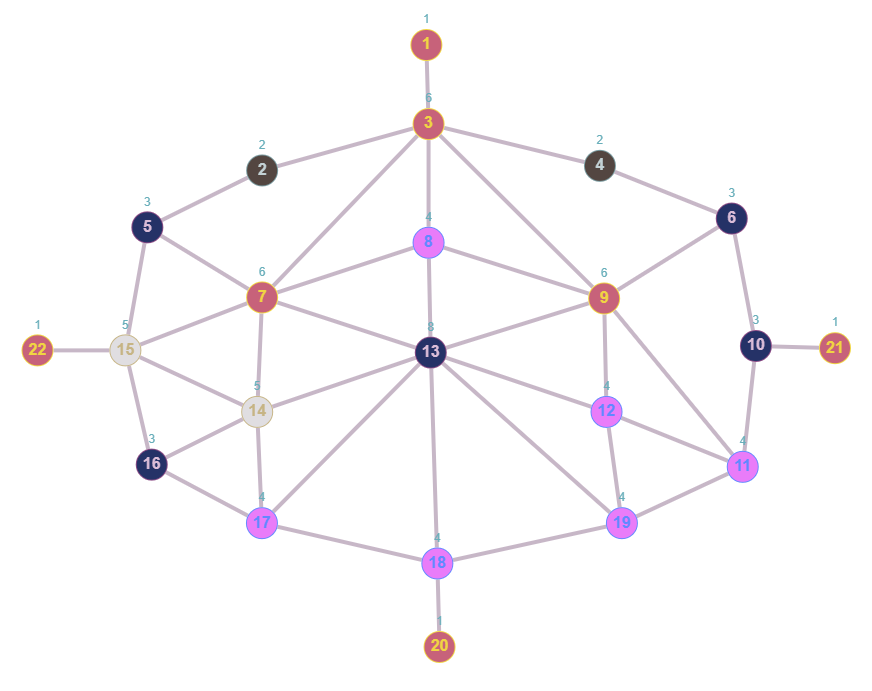

In [ ]:
nodes_number = 22
topology_rep = [
     [3],                   #Node 1
     [3,5],                 #Node 2
     [1,2,4,7,8,9],         #Node 3
     [3,6],                 #Node 4
     [2,7,15],              #Node 5
     [4,9,10],              #Node 6
     [3,5,8,13,14,15],      #Node 7
     [3,7,9,13],            #Node 8
     [3,6,8,11,12,13],      #Node 9
     [6,11,21],             #Node 10
     [9,10,12,19],          #Node 11
     [9,11,13,19],          #Node 12
     [7,8,9,12,14,17,18,19],#Node 13
     [7,13,15,16,17],       #Node 14
     [5,7,14,16,22],        #Node 15
     [14,15,17],            #Node 16
     [13,14,16,18],         #Node 17
     [13,17,19,20],         #Node 18
     [11,12,13,18],         #Node 19
     [18],                  #Node 20
     [10],                  #Node 21
     [15]                   #Node 22
]
max_degree = max([len(topology_rep[i]) for i in range(nodes_number)])

## Metrics assignment

In [ ]:
good_data,epochs = [.0 for _ in range(nodes_number)],[0 for _ in range(nodes_number)]
min_epochs, min_dataquality, max_epochs, max_dataquality = 5, .5, 10, 1.

verbose = False
path = "insert path"

if not verbose:
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
    logging.getLogger('tensorflow').setLevel(logging.FATAL)

## Dataset choice

In [ ]:
# Preload datasets
data_name = 'MNIST' #'FMNIST' #'SPEECH'

if data_name == 'SPEECH':
    DATASET_PATH = 'data/mini_speech_commands'
    data_dir = pathlib.Path(DATASET_PATH)
    if not data_dir.exists():#download if not yet present
        tf.keras.utils.get_file('mini_speech_commands.zip',
                            origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
                            extract=True, cache_dir='.', cache_subdir='data')
    global commands
    commands = np.array(tf.io.gfile.listdir(str(data_dir)))
    commands = commands[commands != 'README.md']
    filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
    filenames = tf.random.shuffle(filenames)
    num_samples = len(filenames)
    train_files = filenames[:6400]
    val_files = filenames[6400: 6400 + 800]
    test_files = filenames[-800:]
    dataset = (train_files,val_files,test_files)
elif data_name == 'MNIST':
    dataset = (keras.datasets.mnist.load_data()) 
elif data_name == 'FMNIST':
    dataset = (keras.datasets.fashion_mnist.load_data())

In [ ]:
#generate optimal distribution -> degree direct proportional with model quality
for i in range(len(topology_rep)):
    degree = len(topology_rep[i])
    epochs[i] = min_epochs + int((degree/max_degree) * (max_epochs - min_epochs))
    good_data[i] = min_dataquality + (degree/max_degree) * (max_dataquality - min_dataquality)

## Generate network

In [ ]:
global pivot
for i in range(nodes_number):
    pivot = i
    run(good_data[i],epochs[i],nodes_number,data_name,i+1,topology_rep,1 if verbose else 0,path,dataset)